##  ResNet 기본 블록 구성하기
---
**ResNet-34**와 **ResNet-50** 네트워크를 직접 만들어 봅시다. 우선 간단하게 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

#### 공톰점    
- conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태

#### 차이점 
- 블록의 내부 구성에서 차이가 있다.  
 **ResNet-34**의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, **ResNet-50**은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가진다.
 
그럼 이제 위의 정보를 생각하면서 ResNet 구조를 만들어 보겠습니다. 

### module import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# conv_layer 부분을 함수로 뽑아서 사용합니다.

def conv_block (output, channel=64, kernel_size =3, strides=2, stage=2, block_num=0, cnn_num=0, flag=False):
    # network 구조에서 맨 처음 시작하는 stage가 아니면서 가장 앞에오는 block일 때 
    # Convolution에서 stride에 2를 적용해  downsampling를 해주어야 한다.
    
    if not flag and block_num ==0 and cnn_num ==0:  
        #print("not flag output.shape  :",  output.shape)
        output = keras.layers.Conv2D(
            filters=channel,
            kernel_size =(kernel_size,kernel_size),
            strides=(strides, strides),
            kernel_initializer='he_normal', # 가중치 초기화
            padding='same',
            name=f'stage{stage}_{block_num+1}_conv{cnn_num+1}'
        )(output)
    else: # 처음 시작부분이 아닌 다른 부분 해당 스테이지에서 시작 부분
        #print("flag True")
        #print("flag output.shape  :",  output.shape)
        output = keras.layers.Conv2D(
            filters=channel,
            kernel_size =(kernel_size,kernel_size),
            kernel_initializer='he_normal', # 가중치 초기화
            padding='same',
            name=f'stage{stage}_{block_num+1}_conv{cnn_num+1}'
        )(output)

    output = keras.layers.BatchNormalization(
        name = f'stage{stage}_{block_num+1}_bn{cnn_num+1}'
    )(output)
    
    return output

In [4]:
# 이전 stage의 Input를 받아서 Conv한 후 return하는 [shortcut] 함수  
def short_cut(shortcut, channel=64, kernel_size =1, stage=2, block_num=0, cnn_num=0, flag=True, is_50=False):
    if not is_50 : # ResNet-34
        # 스테이지에 첫 block인 경우  downsample 진행
        if block_num ==0 and cnn_num+1 == 2 : # ResNet-34는 한 stage 내부의 block 개수가 2개이다.
            strides = 2
        else :
            strides =1

        shortcut = keras.layers.Conv2D(
            filters = channel, 
            kernel_size = (1, 1),
            strides = (strides, strides),
            kernel_initializer='he_normal',
            padding='same',
            name = f'stage{stage}_{block_num+1}_short'
        )(shortcut)
    else : # ResNet-50
           # stage_2 다음의 stage들의 첫 시작시 down sampling 한다.
        if not flag and  block_num ==0 and cnn_num+1 == 3 : # ResNet-50은 한 stage 내부의 block 개수가 3개이다.
            strides = 2
        else :
            strides =1

        shortcut = keras.layers.Conv2D(
            filters = channel, 
            kernel_size = (kernel_size, kernel_size),
            strides = (strides, strides),
            kernel_initializer='he_normal',
            padding='same',
            name = f'stage{stage}_{block_num+1}_short'
        )(shortcut)
                
    shortcut = keras.layers.BatchNormalization(
        name = f'stage{stage}_{block_num+1}_bn{cnn_num+2}'
    )(shortcut)
    
    return shortcut

In [86]:
def build_resnet_block(input_layer,
              channel=64,
              stage=2,
              block_nums=1,
              cnn_num = 2,
              first_channel = 64,
              is_50=False) :   
    # residuall block : 1x1 conv가 앞뒤로 붙은 레이어
    x = input_layer # input layer


    # 시작 레이어의 경우 첫번쨰 Conv를 빼고 다른 스테이지부터 strides = 2를 적용한다
    flag = channel ==  first_channel  # 시작 부분을 제외한 나머지 스테이지는 downsample를 적용한다. (strides=2)
    
    
    init_identity_shortcut = x  # 이전 stage 정보를 담음 shortcut
    
    # block 내부 구성
    if not is_50 : 
        
        for block_num in range(block_nums) :   
                            # 이전 block 레이어
            identity_shortcut = x   # block 하나 단위로 input을 받는다.
            
            # 같은 채널의 3x3 conv block가 2개씩 중첩되어 있는 형태이다.
            for i in range(cnn_num): # residual block가 아닌 경우 ResNet-34

                # 위에 만들어놓은 conv_block에 Argument를 넘겨 줍니다.  
                # flage와 block_num, cnn_num으로 Stage2를 제외한 스테이지에 첫 번째 Conv를 판별해서 
                # downSampling과 Conv layer를 추가합니다.
                x = conv_block(
                    output=x, channel=channel, 
                    kernel_size=3 , strides=2, 
                    stage=stage, block_num=block_num, 
                    cnn_num=i, flag=flag
                )
                if i+1 < cnn_num :  # 마지막 activation은 돌지 않게  
                    x = keras.layers.Activation(
                        'relu',
                    )(x)
                elif not flag:   # stage2가 아닌 경우 shortcut를 사용
                        
                    # shortcut 하기 위해 만든 short_cut() 함수로 short_cut를 output을 만들어 줍니다.
                    init_identity_shortcut = short_cut(
                        shortcut=init_identity_shortcut, channel=channel,
                        stage=stage, block_num=block_num,
                        cnn_num=i,  is_50=is_50
                    )

            if block_num == 0 :
                x = keras.layers.Add(
                    name=f'stage{stage}_{block_num+1}_add' 
                )([x, init_identity_shortcut])
            else : 
                
                x = keras.layers.Add(
                        name=f'stage{stage}_{block_num+1}_add'
                )([x,identity_shortcut]) # short_cut과 기존 레이어 합침
            x = keras.layers.Activation('relu')(x)   # Add 후 rellu로 활성화
                    
                    
        # resNet-34 : conv -> batch ->atcivation -> conv -> batch
    else :  # ResNet-50 구조
        # Conv layer -> BatchNorm -> Activateion의 형태 
        # 마지막 Activation 전에 shortcut를 넣어준다,  
        # 1x1 , 3,3 , 1x1 channel*2
        kernelSize = [1,3,1]
        channels = [channel, channel, channel*4]

        for block_num in range(block_nums) :   
            identity_shortcut = x   # block 하나 단위로 input을 받는다.
            
            for (i, kernel_size, channel) in zip(range(cnn_num), kernelSize, channels ): # residual block가 아닌 경우 ResNet-34
                 # 같은 채널의 3x3 conv block가 2개씩 중첩되어 있는 형태이다.

                # 위에 만들어놓은 conv_block에 Argument를 넘겨 줍니다.  
                # flage와 block_num, cnn_num으로 Stage2를 제외한 스테이지에 첫 번째 Conv를 판별해서 
                # downSampling과 Conv layer를 추가합니다.
                x = conv_block(
                    output=x, channel=channel, 
                    kernel_size=kernel_size, strides=2, 
                    stage=stage, block_num=block_num, 
                    cnn_num=i, flag=flag
                )
                if i+1 < cnn_num :  # 마지막 activation은 돌지 않게  
                    x = keras.layers.Activation(
                        'relu'
                    )(x)
                else :  # 모든 stage에 대해 shortcut를 적용 
                        # 첫 stage의 경우 downsampling를 하지 않는다.
                    # shortcut 하기 위해 만든 short_cut() 함수로 short_cut를 output을 만들어 줍니다.
                    init_identity_shortcut = short_cut(
                        shortcut=init_identity_shortcut, channel=channel,
                        stage=stage, block_num=block_num,
                        cnn_num=i, flag=flag,  is_50=is_50
                    )

            if block_num == 0 :
                x = keras.layers.Add(
                    name=f'stage{stage}_{block_num+1}_add' 
                )([x, init_identity_shortcut])
            else : 
                x = keras.layers.Add(
                        name=f'stage{stage}_{block_num+1}_add'
                )([x,identity_shortcut]) # short_cut과 기존 레이어 합침

            x = keras.layers.Activation('relu')(x)   # Add 후 rellu로 활성화
        

    return x

In [128]:
resnet_input_layer = keras.layers.Input(shape=(8,8,64)) # input 레이어 생성
#resnet_block_output = build_resnet_block(resnet_input_layer, is_50=True)
resnet_block_output = build_resnet_block(resnet_input_layer)

In [129]:
# 블록 1개짜리 model 생성
# resnet-34
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 8, 8, 64)]   0                                            
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     36928       input_48[0][0]                   
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_1186 (Activation)    (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
______________________________________________________________________________________

In [117]:
# 블록 1개짜리 model 생성
# resnet-50
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 8, 8, 64)]   0                                            
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     4160        input_43[0][0]                   
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_1096 (Activation)    (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
______________________________________________________________________________________

## 2) ResNet-34, ResNet-50 Complete Model
---
직접 ResNet 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 **build_resnet()**를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

ResNet의 block 구조를 담당하는 **build_resnet_block**에서 resnet-34일 때의 block 구조 resnet-50일때의 block 구조를 설계합니다.  
**build_resnet**에서 resnet을 구성할 channel과 스테이지별 block의 개수 block 내부 layer 개수등을 입력받을 수 있게 만듭니다.

In [87]:
# resnet 모델 자체를 생성하는 함수입니다
def build_resnet(input_shape=(32,32,3),
              channel_list=[64,128,256,512],
              block_num_list=[3,4,6,3],
              cnn_num_list=[2,2,2,2],   
              stage=2,
              num_classes=10,
                is_50=False): 

    # default -> ResNet-34 기준
    
    assert len(cnn_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # 반복되지 않는 부분 7x7, 64, strides=2
    # pool /2 
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        kernel_initializer='he_normal', # 가중치 초기화
        padding='same',
        strides=2
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
 
    output = keras.layers.MaxPooling2D(
        pool_size=(3,3), 
        strides=2, 
        padding='same',
        name=f'stage{stage}_0_maxpooling'
    )(output)
    
    #print(output.shape)
    if not is_50 :   # resnet-34
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        for i, (cnn_num, channel,block_num) in enumerate(zip(cnn_num_list, channel_list, block_num_list)):
            output = build_resnet_block(
                output,
                stage=(i+2),
                block_nums=block_num,
                cnn_num=cnn_num, 
                channel=channel,
            )
    else:
        cnn_num_list = [3,3,3,3]
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        for i, (cnn_num, channel,block_num) in enumerate(zip(cnn_num_list, channel_list, block_num_list)):
            output = build_resnet_block(
                output,
                stage=(i+2),
                block_nums=block_num,
                cnn_num=cnn_num, 
                channel=channel,
                is_50=is_50
            )
        

    output = keras.layers.AveragePooling2D(
        pool_size=(1,1),
        name='avg_pool'
    )(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(
        num_classes,
        activation='softmax',
        name='fc1000'
    )(output)


    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
        
    return model

In [62]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 64)   9472        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 16, 16, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_91 (Activation)      (None, 16, 16, 64)   0           batch_normalization_11[0][0]     
_______________________________________________________________________________________

resnet-34을 모델 구조로 시각화 하면 다음과 같습니다.

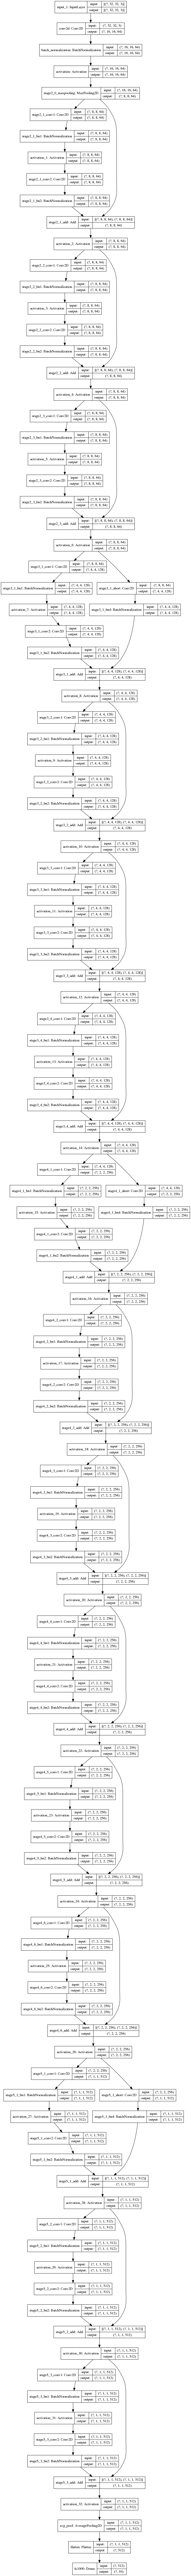

In [6]:
tf.keras.utils.plot_model(resnet_34, show_shapes=True,rankdir='LB')

### ResNet-50 build
ResNet-50을 build_resnet() 함수를 사용해 생성하겠습니다.


In [89]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 64)   9472        input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 16, 16, 64)   256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_325 (Activation)     (None, 16, 16, 64)   0           batch_normalization_21[0][0]     
______________________________________________________________________________________

resnet-50을 모델 구조로 시각화 하면 다음과 같습니다.

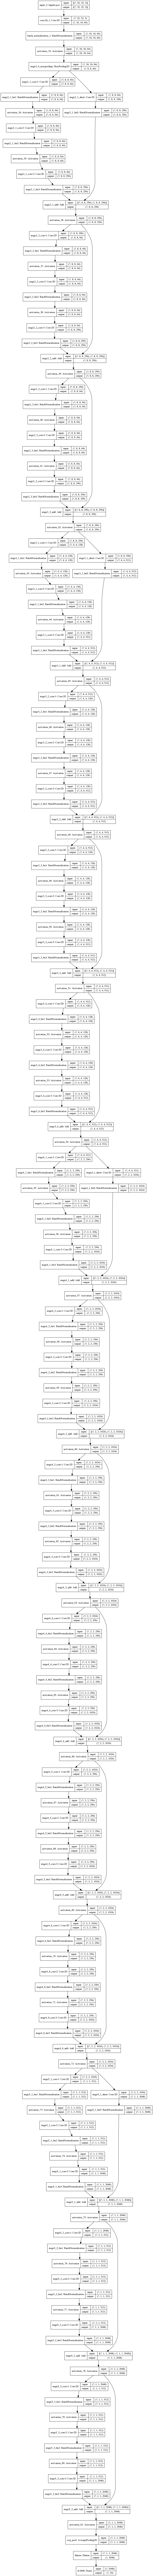

In [8]:
tf.keras.utils.plot_model(resnet_50, show_shapes=True,rankdir='LB')

#### ResNet-34의 Params

============================   
> **Total params**: 21,315,338   
> **Trainable params**: 21,298,314   
> **Non-trainable params**: 17,024   
 
============================

#### ResNet-50의 Params

============================   
> **Total params**: 23,608,202   
> **Trainable params**: 23,555,082   
> **Non-trainable params**: 53,120   
 
============================



ResNet-34와 ResNet-50의 가장 큰 차이점은 한 block내의 layer의 개수와 kernel_size, channel의 값이 가장 큰 차이점이리고 볼 수 있습니다.  
ResNet-34의 경우 (3x3, 64), (3x3, 64)이면 ResNet-50은 (1x1, 64), (3x3, 64), (1x1, 64 x 4)으로 
ResNet-34의 kernel_size는 (3x3), (3x3)으로 동일하지만 ResNet-50은 (1x1), (3x3), (1x1)으로 kernel_size가 다르고 channel도 ResNet-34는 [64, 64]로 동일한 반면에 ResNet-50은 [64, 64, 256]으로 마지막 layer는 기존 channel의 4배가 되는 구조를 가지고 있습니다.  

추가적으로 구현할 때 알아야 했던 차이는 바로 ResNet-34의 경우 stage2에선 **stage2_1_short (Conv2D)** [이전 입력을 Conv] 부분이 들어가지 않지만, ResNet-50의 경우 channel의 4배가 되므로 해당 channel을 맞춰주기 위해 **stage2_1_short (Conv2D)**가 적용된다는 차이가 있습니다. 

## 3) 일반 네트워크(plain network) 만들기
---
#### 블록 코드 수정하기 [plain network추가]
ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다.   
위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 보겠습니다.  

#### 전체 함수 코드 수정하기

위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 **build_plainnet()**를 만들어 보세요. 이때 입력 이미지의 크기는 **(224, 224, 3)**으로 해주세요.

In [5]:
# 기존 resnet에서  shortcut가 없이 layer를 쌓은 일반 네트워크의 block 구조를 담당하는 함수입니다.
def build_plainnet_block(input_layer,
              channel=64,
              stage=2,
              block_nums=1,
              cnn_num = 2,
              first_channel = 64,
              is_50=False) :   
    # residuall block : 1x1 conv가 앞뒤로 붙은 레이어
    x = input_layer # input layer

    # 시작 레이어의 경우 첫번쨰 Conv를 빼고 다른 스테이지부터 strides = 2를 적용한다
    flag = channel ==  first_channel  # 시작 부분을 제외한 나머지 스테이지는 downsample를 적용한다. (strides=2)
    
    # block 내부 구성
    if not is_50 : 
        
        for block_num in range(block_nums) :   
            for i in range(cnn_num): # residual block가 아닌 경우 ResNet-34
                 # 같은 채널의 3x3 conv block가 2개씩 중첩되어 있는 형태이다.
                 # 위에서 만든 conv_block 사용
                x = conv_block(
                    output=x, channel=channel, 
                    kernel_size=3 , strides=2, 
                    stage=stage, block_num=block_num, 
                    cnn_num=i, flag=flag
                )
                x = keras.layers.Activation(
                    'relu',
                )(x)

                    
                    
        # plain Net-34 : conv -> batch ->atcivation -> conv -> batch -> atcivation
    else :  # plain Net-50 
        # Conv layer -> BatchNorm -> Activateion을 3번 반복한 형태 
        # 1x1 , 3,3 , 1x1 channel*4  # channel과 kernel_size의 차이가 있다.
        kernelSize = [1,3,1]
        channels = [channel, channel, channel*4]

        for block_num in range(block_nums) :   
            for (i, kernel_size, channel) in zip(range(cnn_num), kernelSize, channels ): # residual block가 아닌 경우 ResNet-34
                 # 위에서 만든 conv_block 사용
                x = conv_block(
                    output=x, channel=channel, 
                    kernel_size=kernel_size , strides=2, 
                    stage=stage, block_num=block_num, 
                    cnn_num=i, flag=flag
                )
                x = keras.layers.Activation(
                    'relu',
                )(x)

    return x

In [6]:
# resnet 모델 자체를 생성하는 함수입니다
def build_plainnet(input_shape=(32,32,3),
              channel_list=[64,128,256,512],
              block_num_list=[3,4,6,3],
              cnn_num_list=[2,2,2,2],   
              stage=2,
              num_classes=10,
                is_50=False): 

    # default -> ResNet-34 기준
    
    assert len(cnn_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # 반복되지 않는 부분 7x7, 64, strides=2
    # pool /2 
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        kernel_initializer='he_normal', # 가중치 초기화
        padding='same',
        strides=2
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)

 
    output = keras.layers.MaxPooling2D(
        pool_size=(3,3), 
        strides=2, 
        padding='same',
        name=f'stage{stage}_0_maxpooling'
    )(output)
    

    if not is_50 :   # resnet-34
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        for i, (cnn_num, channel,block_num) in enumerate(zip(cnn_num_list, channel_list, block_num_list)):
            output = build_plainnet_block(
                output,
                stage=(i+2),
                block_nums=block_num,
                cnn_num=cnn_num, 
                channel=channel,
            )
    else:
        cnn_num_list = [3,3,3,3]
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        for i, (cnn_num, channel,block_num) in enumerate(zip(cnn_num_list, channel_list, block_num_list)):
            output = build_plainnet_block(
                output,
                stage=(i+2),
                block_nums=block_num,
                cnn_num=cnn_num, 
                channel=channel,
                is_50=is_50
            )
        

    # avg-pool 사용시 pooling 단계엣서 1차원 벡터로 만들어 지지 않으므로, 
    # feature를 1차원 벡터로 만들기 위해  GAP를 사용한다.
    output = keras.layers.AveragePooling2D(
        pool_size=(1,1),
        name='avg_pool'
    )(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(
        num_classes,
        activation='softmax',
        name='fc1000'
    )(output)


    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
        
    return model

In [7]:
# tensorflow의 데이터셋인 dogs_vs_cats 를 데이터셋으로 사용하기 전에   
# 같은 크기인 (224,224,3)을 input_shape에 넣어 parameter를 살펴보겠습니다. 
plain_34 = build_plainnet(input_shape=(224,224, 3), num_classes=1)
plain_34.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

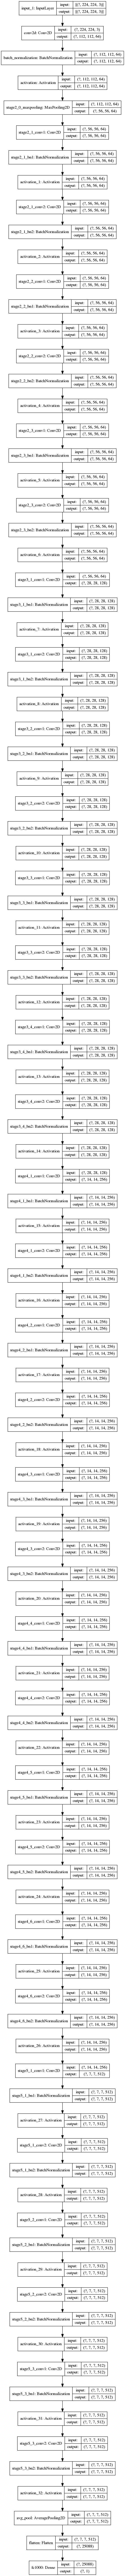

In [10]:
tf.keras.utils.plot_model(plain_34, show_shapes=True)

In [11]:
# dog and cat 2개를 분류해서 하나의 결과만 나와야 하니 num_classes=1 이다.
plain_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True, num_classes=1)
plain_50.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_33 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)       

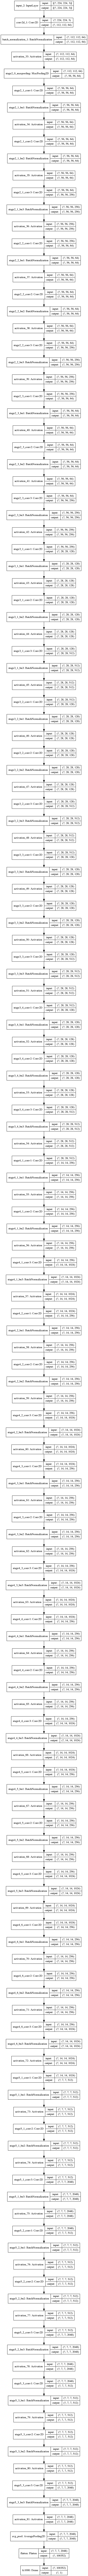

In [12]:
tf.keras.utils.plot_model(plain_50, show_shapes=True)

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---

#### Ablation Study

ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다   
ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정하겠습니다.

데이터셋으로는 **tensorflow-datasets**에서 제공하는 **cats_vs_dogs** 데이터셋을 다루어 보겠습니다. 

#### 시각화
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.


텐서플로우 데이터셋의 **cats_vs_dogs** 데이터를 사용해 학습의 차이를 살펴보겠습니다. 

---

## cats_vs_dogs datasets 가져오기 

In [33]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [34]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [35]:
# Tensorflow 데이터셋을 로드했으니 feature 정보와 데이터 셋의 info를 확인해 봅시다. 
# info를 확인하면 개와 고양이의 2개의 클래스를 가졌으므로 num_classes=2인 것을 확인할 수 있습니다.
# 그리고 데이터셋 저자와 년도 등의 대한 정보도 나와 있네요.
print(ds_info.features)

ds_info

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/ssac27/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCH

In [36]:
# 데이터의 개수도 확인해 봅시다. 
# dataset이 numpy가 아니므로 .shape를 사용하지 못한다.
ds_train_shape =  tf.data.experimental.cardinality(ds_train)
ds_test_shape = tf.data.experimental.cardinality(ds_test)
ds_valid_shape = tf.data.experimental.cardinality(ds_valid)

In [37]:
print("ds_train_shape : ", ds_train_shape)
print("ds_test_shape :  ", ds_test_shape)
print("ds_valid_shape : ", ds_valid_shape)

ds_train_shape :  tf.Tensor(18610, shape=(), dtype=int64)
ds_test_shape :   tf.Tensor(2326, shape=(), dtype=int64)
ds_valid_shape :  tf.Tensor(2326, shape=(), dtype=int64)


데이터가 8:1:1 정도로 나뉘어 진것을 확인할 수 있습니다.

In [38]:
# label명 확인
ds_info.features['label'].names

['cat', 'dog']

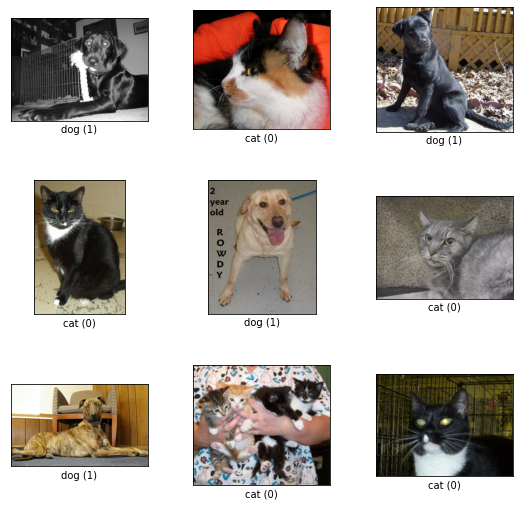

In [39]:
# 어떤 이미지가 있는지 한번 확인해 봅시다. 
# train_set
fig = tfds.show_examples(ds_train, ds_info)

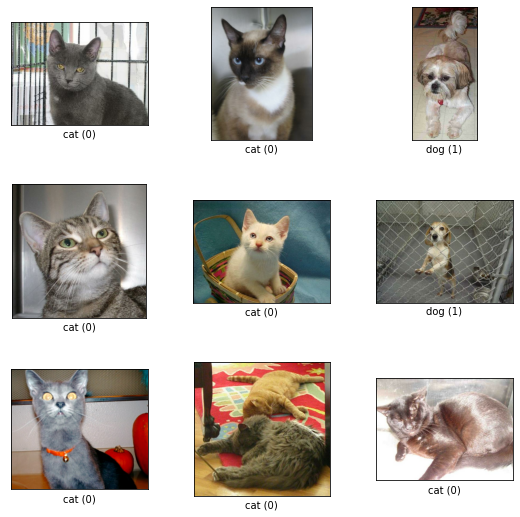

In [40]:
# test_set 데이터 이미지 확인
fig = tfds.show_examples(ds_test, ds_info)

### Normalization

위의 이미지를 보시면 각 이미지마다 크기가 제각각 다른것을 알 수 있습니다. 이런 경우 학습이 제대로 진행되지 않으므로 같은 사이즈로 이미지의 크기를 맞추어줘야 합니다.   

데이터의 이미지 크기를 같은 크기로 맞추는 resize 작업을 통해 **(224,224)**의 크기로 맞추는 작업을 진행하겠습니다.  
그리고 각 채널별 최댓값인 255로 **정규화(normalize)**를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어주겠습니다.  

In [41]:
BATCH_SIZE = 16
EPOCH = 7

In [42]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [43]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [44]:
# train, valid, test  데이터셋의 정규화를 해줍니다.
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, is_test=False, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

### ResNet-34 Vs plain_34 
ResNet34와 Plain_34를 학습하고 비교해 보겠습니다.

In [45]:
# dog and cat 2개를 분류해서 하나의 결과를 출력해야 하니 num_classes=1이다
resnet_34 = build_resnet(input_shape=(224, 224, 3),  num_classes=1)
resnet_34.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 112, 112, 64) 256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 112, 112, 64) 0           batch_normalization_3[0][0]      
_______________________________________________________________________________________

In [46]:
# 클래스 2개를 가지고 분류를 하니 loss를 binary_crossentropy로 해야한다.
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    metrics=['accuracy'],
)

resnet_34_history = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape//BATCH_SIZE),
    validation_steps=int(ds_test_shape//BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1
)

Epoch 1/7
1163/1163 [==============================] - 92s 79ms/step - loss: 1.1571 - accuracy: 0.5328 - val_loss: 1.8529 - val_accuracy: 0.5186
Epoch 2/7
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6642 - accuracy: 0.5990 - val_loss: 0.6924 - val_accuracy: 0.5750
Epoch 3/7
1163/1163 [==============================] - 90s 78ms/step - loss: 0.6309 - accuracy: 0.6405 - val_loss: 100.5026 - val_accuracy: 0.5323
Epoch 4/7
1163/1163 [==============================] - 90s 77ms/step - loss: 0.6513 - accuracy: 0.6102 - val_loss: 0.7803 - val_accuracy: 0.6034
Epoch 5/7
1163/1163 [==============================] - 90s 77ms/step - loss: 0.6585 - accuracy: 0.6360 - val_loss: 0.6020 - val_accuracy: 0.6632
Epoch 6/7
1163/1163 [==============================] - 90s 77ms/step - loss: 0.5769 - accuracy: 0.6950 - val_loss: 0.8897 - val_accuracy: 0.6078
Epoch 7/7
1163/1163 [==============================] - 88s 76ms/step - loss: 0.5659 - accuracy: 0.6996 - val_loss: 0.5643 - val_

In [47]:
# dog and cat 2개를 분류해서 하나의 결과를 출력해야 하니 num_classes=1이다
plain_34 = build_plainnet(input_shape=(224, 224, 3), num_classes=1)

In [48]:
# 클래스 2개를 가지고 분류를 하니 loss를 binary_categorical로 해야한다.
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    metrics=['accuracy'],
)

plain_34_history = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape//BATCH_SIZE),
    validation_steps=int(ds_test_shape//BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1
)

Epoch 1/7
1163/1163 [==============================] - 84s 73ms/step - loss: 0.9227 - accuracy: 0.5130 - val_loss: 0.6833 - val_accuracy: 0.4974
Epoch 2/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6837 - accuracy: 0.5403 - val_loss: 0.6951 - val_accuracy: 0.5567
Epoch 3/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6950 - accuracy: 0.5025 - val_loss: 0.6921 - val_accuracy: 0.5057
Epoch 4/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6943 - accuracy: 0.5109 - val_loss: 0.7200 - val_accuracy: 0.5675
Epoch 5/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6879 - accuracy: 0.5289 - val_loss: 0.6869 - val_accuracy: 0.5621
Epoch 6/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6914 - accuracy: 0.5216 - val_loss: 0.6932 - val_accuracy: 0.4892
Epoch 7/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.7077 - accuracy: 0.5248 - val_loss: 0.6841 - val_ac

In [65]:
def loss_graph(x_history, y_history, x_network, y_network, x_name='ResNet', y_name='Plain') :
    plt.plot(x_history.history['loss'], 'go-')
    plt.plot(y_history.history['loss'], 'bo-')
    plt.title('Model Training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([x_name+'-'+str(x_network), y_name+'-'+str(y_network)], loc='upper left')
    plt.show()

In [68]:
def acc_graph(x_history, y_history, x_network, y_network, x_name='ResNet', y_name='Plain') :
    plt.plot(x_history.history['val_accuracy'], 'go-')
    plt.plot(y_history.history['val_accuracy'], 'bo-')
    plt.title('Model Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([x_name+'-'+str(x_network), y_name+'-'+str(y_network)], loc='upper left')
    plt.show()

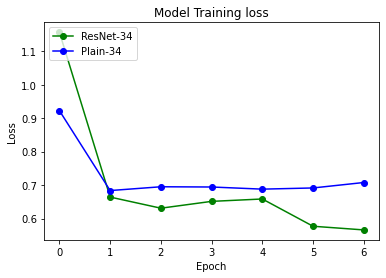

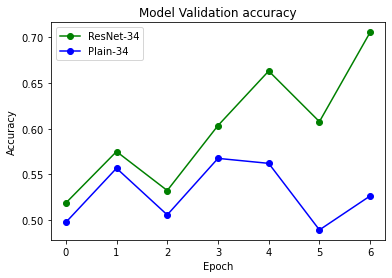

In [89]:
loss_graph(resnet_34_history, plain_34_history, 34,34)
acc_graph(resnet_34_history, plain_34_history, 34,34)

ResNet-34와 Plain-34의 차이는 shortcut을 하냐 안하냐의 차이지만, 그래프를 보면 그 차이가 많은 영향을 끼치는 것을 확인할 수 있습니다.  
Loss를 보면 Plain은 Epoch 1 부터 큰 차이가 없으며 다시 올라가는 모습을 보이지만, ResNet은 계속 감소하고 있습니다.  
accuracy에서도 Plain은 0.5 근처에서 변화가 크게 일어나진 않지만, ResNet은 0.5를 넘어 0.7 이상으로 상승하는 모습을 보입니다.  

### ResNet-50 Vs Plain-50
ResNet-50과 Plain-50를 학습하고 비교해 보겠습니다.

In [52]:
# dog and cat 2개를 분류해서 하나의 결과를 출력해야 하니 num_classes=1이다
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True,  num_classes=1)

In [53]:
# 클래스 2개를 가지고 분류를 하니 loss를 binary_crossentropy로 해야한다.
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    metrics=['accuracy'],
)

resnet_50_history = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape//BATCH_SIZE),
    validation_steps=int(ds_test_shape//BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1
)

Epoch 1/7
1163/1163 [==============================] - 151s 130ms/step - loss: 2.1235 - accuracy: 0.5471 - val_loss: 0.8087 - val_accuracy: 0.5483
Epoch 2/7
1163/1163 [==============================] - 195s 167ms/step - loss: 0.6985 - accuracy: 0.6098 - val_loss: 2.0143 - val_accuracy: 0.6221
Epoch 3/7
1163/1163 [==============================] - 150s 129ms/step - loss: 0.6379 - accuracy: 0.6531 - val_loss: 0.7539 - val_accuracy: 0.6586
Epoch 4/7
1163/1163 [==============================] - 150s 129ms/step - loss: 0.5636 - accuracy: 0.7039 - val_loss: 0.8207 - val_accuracy: 0.6091
Epoch 5/7
1163/1163 [==============================] - 150s 129ms/step - loss: 0.5544 - accuracy: 0.7247 - val_loss: 2.0632 - val_accuracy: 0.6082
Epoch 6/7
1163/1163 [==============================] - 150s 129ms/step - loss: 0.5493 - accuracy: 0.7296 - val_loss: 0.6383 - val_accuracy: 0.7177
Epoch 7/7
1163/1163 [==============================] - 150s 129ms/step - loss: 0.4973 - accuracy: 0.7594 - val_loss: 0

In [54]:
# dog and cat 2개를 분류해서 하나의 결과를 출력해야 하니 num_classes=1 이다
plain_50 = build_plainnet(input_shape=(224, 224, 3), num_classes=1)

In [55]:
# 클래스 2개를 가지고 분류를 하니 loss를 binary_categorical로 해야한다.
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.002),
    metrics=['accuracy'],
)

plain_50_history = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_shape//BATCH_SIZE),
    validation_steps=int(ds_test_shape//BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1
)

Epoch 1/7
1163/1163 [==============================] - 85s 73ms/step - loss: 0.9683 - accuracy: 0.4989 - val_loss: 0.7221 - val_accuracy: 0.4939
Epoch 2/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6876 - accuracy: 0.5338 - val_loss: 0.6821 - val_accuracy: 0.5168
Epoch 3/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6817 - accuracy: 0.5456 - val_loss: 5.1094 - val_accuracy: 0.5203
Epoch 4/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6821 - accuracy: 0.5476 - val_loss: 0.6985 - val_accuracy: 0.4801
Epoch 5/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6788 - accuracy: 0.5606 - val_loss: 0.7026 - val_accuracy: 0.4716
Epoch 6/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6738 - accuracy: 0.5743 - val_loss: 0.7631 - val_accuracy: 0.4780
Epoch 7/7
1163/1163 [==============================] - 84s 72ms/step - loss: 0.6782 - accuracy: 0.5615 - val_loss: 0.8570 - val_ac

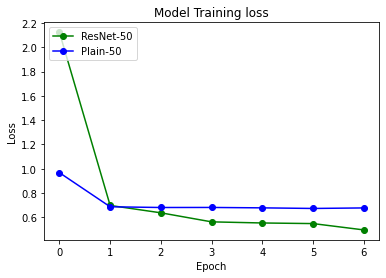

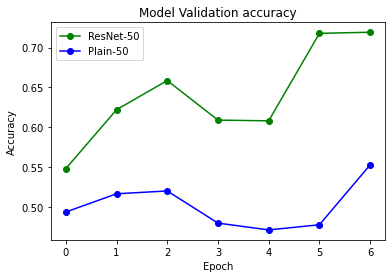

In [88]:
loss_graph(resnet_50_history, plain_50_history, 50,50)
acc_graph(resnet_50_history, plain_50_history, 50,50)

ResNet-50과 Plain-50을 비교해 봤을때 예상대로 ResNet-50의 성능이 월등하게 좋아보입니다.  
loss를 보면 Plain과 ResNeet과 큰 차이가 없어 보이지만, 그래프를 잘 보면 Plain은 Epoch 1 부터 변화가 거의 없지만,  ResNet은 천천히 꾸준하게 감소하는것을 확인할 수 있습니다.  

### ResNet-50 Vs ResNet-34 
ResNet-50과 ResNet-34를 비교하겠습니다.  

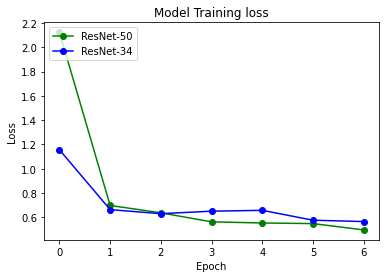

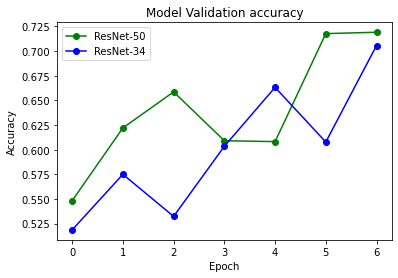

In [82]:
loss_graph(resnet_50_history, resnet_34_history, 50, 34)
acc_graph(resnet_50_history, resnet_34_history, 50, 34)

ResNet-50과 ResNet-34의 차이는 **Residual block**이냐 아니면 **plain block**이냐의 문제인데 좀 더 정확한 결과를 보려면 훨씬 더 Epoch를 돌려야 겠지만, 추이만 살피고자 Epoch를 7정도만 반복시켰습니다.      
두 네트워크의 성능은 비슷하지만 시각화를 해보니 ResNet-50의 성능이 좀 더 좋은것 같습니다.  

### Plain-50 Vs Plain-34 
Plain network에서 더 깊은 layer인 50과 상대적으로 더 얕은 layer인 34를 비교해보겠습니다.

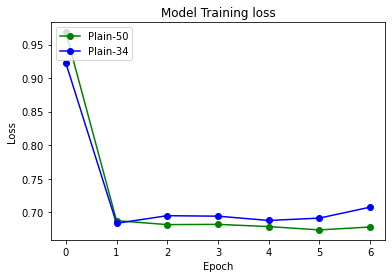

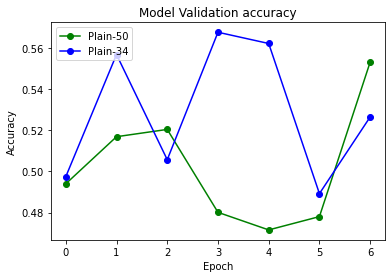

In [95]:
loss_graph(plain_50_history, plain_34_history, 50, 34, x_name='Plain')
acc_graph(plain_50_history, plain_34_history,  50, 34, x_name='Plain')

학습 EPOCH가 7로 길지 않아서 오버 피팅되는 문제는 발생하지 않았지만 그래도 학습 loss와 accuracy를 보면 **ResNet**에 비해 불안정한 Accuracy 그래프를 보이고 있습니다.  
loss도 ResNet에 비해 더 높은 loss값을 가지고 있네요.  

그리고 기존의 학습의 깊이가 깊어서 생기는 Vanishing Gradient가 짧은 Epoch로 발생하지 않아서 Plain-50이 더 괜찮은 그래프를 그리는것 같습니다.   

- 불안정한 그래프와 layer의 수를 봤을때 EPOCH가 50정도만 되어도 Plain-34가 Plain-50보다 좀 더 나은 결과를 보일 것 같습니다.  [Vanishing Gradient 문제]

### ResNet-34 Vs Plain-50
---
더 얕은 layer를 쌓은 ResNet과 더 깊은 layer 구조를 가진 Plain Network를 비교해보겠습니다.  

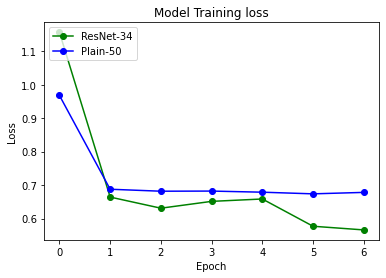

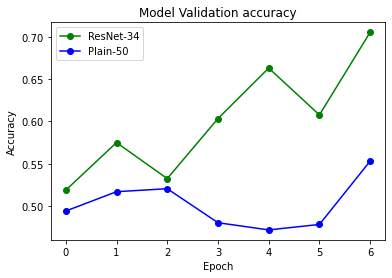

In [20]:
loss_graph(resnet_50_history, plain_50_history, 34, 50)
acc_graph(resnet_50_history, plain_50_history,  34, 50)

Epoch가 짧아서 Plain-50이 더 좋은 결과를 어쩌면 보일 수 있을것 같다고 생각했지만, Epoch 2까지만 비슷하고 그 후로는 ResNet이 월등한 성능차이를 보이고 있네요.

### history pickle save 
model의 history를 나중에 비교를 하고 싶을때 사용할 수 있게 save를 해서 후에 사용할 수 있게 만듭니다.

In [4]:
import pickle

In [101]:
import pickle

with open('./history/resnet-34_history', mode='wb') as file_pi:
    pickle.dump(resnet_34_history.history, file_pi)

In [102]:
with open('./history/resnet-50_history', mode='wb') as file_pi:
    pickle.dump(resnet_50_history.history, file_pi)

In [103]:
with open('./history/Plain-34_history', mode='wb') as file_pi:
    pickle.dump(plain_34_history.history, file_pi)

In [104]:
with open('./history/Plain-50_history', mode='wb') as file_pi:
    pickle.dump(plain_50_history.history, file_pi)

In [8]:
history_resnet34 = pickle.load(open('./history/resnet-34_history', "rb"))

In [7]:
history_plain50 = pickle.load(open('./history/Plain-50_history', "rb"))

---

## Ablation 결과표

![Ablation_table.jpg](./image/Ablation_table.jpg)

<br>

## 회고

- 많이 들었고 공부했던 ResNet 구조를 처음 짜려고 했을때만 해도 이론을 알고 있으니까 할만하겠지 라고 생각했습니다.  그렇지만 실제로 해보니 생각보다 잘 되지 않았고 layer도 Sequential로 만들지 않고 익숙지 않은 Functional로 짜다 보니 오류가 더 발생한것 같고 오류를 제대로 못본것 같습니다.   
예를들면 **x = keras.layers.Conv2D(...)(x)** 이렇게 작성해야 하는데 **output = keras.layers.Conv2D(...)(x)** 으로 Functional 구조가 익숙지 않아서 이런 오류를 빨리 찾지 못하고 몇시간 동안 찾은 경우가 종종 있었네요.


- ResNet은 워낙 많이 얘기를 들었고 어떤 구조로 이루어졌는지에 대해서도 그림으로도 보고 글로도 보고 해서 금방 네트워크를 만들겠다 했지만, 막상 해보니 뭐든지 직접 해봐야 된다는 것을 알게된것 같습니다.  
ResNet을 구성할 때 절대로 구글에서 직접 코드를 보지 않고 이론과 관련 그림으로만 코드를 작성하려고 해서 시간이 더 오래 걸리고 오류가 군데군데 발생하는 문제들이 생겼지만, 이렇게 직접 해보니 ResNet의 개념적인 이해뿐만 아니라 실제 코드에서의 이해도 더 늘어난것 같습니다.  


- '금방 끝날것 같은데' 하면서도 시간이 오래 걸려서 스트레스를 받았지만, 그래도 문제 없이 마치니 자신감이 더 생기는것 같습니다.  



- 쉬운것 같으면서 어려웠고 그래서 스트레스 받았지만 재밌었던 이론만가지고 ResNet 구조 코드 구현 보람찼습니다. 